# Porto Seguro의 운전자 보험청구 예측 (for beginner)
**Porto Seguro's Safe Driver Prediction**  <br>

* Data Preparation & Exploration
    * https://www.kaggle.com/bertcarremans/data-preparation-exploration

-----------------------------
### 대회 설명
운전자가 내년에 보험 청구를 할 것인지를 예측하는 대회.<br>
58개의 컬럼과 1개의 Target 컬럼으로 이루어져있음

### Normalized Gini Coefficient (지니계수)
* 머신러닝 분야에서 Decision Tree모델의 성능을 평가할 때 엔트로피 지수와 함께 쓰인다. 
    * 결정트리는 트리구조를 형성할때 순도가 증가하고, 불순도가 최대한 작아지는 방향으로 결정을 내려감.
* 지니 계수는 0~0.5 의 값을 가지는데 값이 작을수록 분류가 잘 되었다고 볼 수 있음
    * 불순도(섞인 정도)가 적은것이 분류가 잘된것
* 이 대회에서 지니 계수는 Actual 값의 누적 비율과 Prediciton값의 누적 비율로 산출이되는데, 이것을 표준화 시킨다.
    * 이 표준화는 Actual값이 가지고 있는 불평등 정도로 actual-prediction간의 불평등 정도를 나누어서 산출된다.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/porto-seguro-safe-driver-prediction/sample_submission.csv
/kaggle/input/porto-seguro-safe-driver-prediction/train.csv
/kaggle/input/porto-seguro-safe-driver-prediction/test.csv


-----------------------------
### Introduction
1. Visual inspection of your data
2. Defining the metadata
3. Descriptive statistics
4. Handling imbalanced classes
5. Data quality checks
6. Exploratory data visualization
7. Feature engineering
8. Feature selection
9. Feature scaling
-----------------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100)

In [3]:
import os
print(os.listdir("../input"))

['porto-seguro-safe-driver-prediction']


### Loading data

In [4]:
train = pd.read_csv('../input/porto-seguro-safe-driver-prediction/train.csv')
test = pd.read_csv('../input/porto-seguro-safe-driver-prediction/test.csv')

### Data at first sight
**데이터 특징** <br>
1. 컬럼 이름(ind, reg, car, calc)로 Grouping된다
2. 컬럼 이름에 '_bin'은 Binary Features, '_cat'은 Categorical Features를 의미
3. 컬럼 이름에 아무것도 안붙어있으면 Continuous or Ordinal Features를 의미
4. -1 은 Null값을 의미

In [5]:
train.shape

(595212, 59)

In [6]:
# 중복되는 row가 있는지 확인하기위해 drop_duplicates()사용

train.drop_duplicates()
train.shape

(595212, 59)

In [7]:
test.shape

(892816, 58)

In [8]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [9]:
train.tail()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
595207,1488013,0,3,1,10,0,0,0,0,0,1,0,0,0,0,0,13,1,0,0,0.5,0.3,0.692820,10,1,-1,0,1,1,1,1,0,1,31,3,0.374166,0.684631,0.385487,2.645751,0.4,0.5,0.3,3,0,9,0,9,1,12,4,1,9,6,0,1,1,0,1,1
595208,1488016,0,5,1,3,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0.9,0.7,1.382027,9,1,-1,0,-1,15,0,0,2,1,63,2,0.387298,0.972145,-1.000000,3.605551,0.2,0.2,0.0,2,4,8,6,8,2,12,4,1,3,8,1,0,1,0,1,1
595209,1488017,0,1,1,10,0,0,1,0,0,0,0,0,0,0,0,12,1,0,0,0.9,0.2,0.659071,7,1,-1,0,-1,1,1,1,2,1,31,3,0.397492,0.596373,0.398748,1.732051,0.4,0.0,0.3,3,2,7,4,8,0,10,3,2,2,6,0,0,1,0,0,0
595210,1488021,0,5,2,3,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.9,0.4,0.698212,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.764434,0.384968,3.162278,0.0,0.7,0.0,4,0,9,4,9,2,11,4,1,4,2,0,1,1,1,0,0
595211,1488027,0,0,1,8,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.1,0.2,-1.000000,7,0,-1,0,-1,0,1,0,2,1,34,2,0.400000,0.932649,0.378021,3.741657,0.4,0.0,0.5,2,3,10,4,10,2,5,4,4,3,8,0,1,0,0,0,0


In [10]:
# _cat로 끝나는 14개의 categorical 변수에 대해서 더미변수를 만들것이다.
# _bin으로 끝나는 binary 변수는 이미 binary이기때문에 더미화할필요없음.
## 아래 info를 보면, 데이터 타입이 int 또는 float이다. null값은 -1로 되어있기 때문에 전부 non-null로나옴. 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

### Metadata
데이터 관리를 용이하게 하기 위해서 변수에대한 meta정보를 DataFrame에저장할것이다.<br>
이는 이후 분석, 시각화, 모델링시에 유용하다
> * role : input, ID, target
* level:norminal(명목변수), interval(간격변수), ordinal(순위변수), binary
    * (참고) 명목변수, 순위변수는 범주형변수에 속함. 간격변수는 연속형변수
* keep: True or False
* dtype : int, float, str

**Python-Exercise [1]**


In [11]:
"""
list에 for loop돌면서 딕셔너리를 append해주고, 최종적으로 DataFrame으로 만들어주는 방식
"""

data=[]
data.append({'varname':'var1','dtype':'int'})  # 1st for loop
data

[{'varname': 'var1', 'dtype': 'int'}]

In [12]:
data.append({'varname':'var2','dtype':'float'})  # 2nd for loop
data

[{'varname': 'var1', 'dtype': 'int'}, {'varname': 'var2', 'dtype': 'float'}]

In [13]:
# final DataFrame
pd.DataFrame(data)

,varname,dtype
0,var1,int
1,var2,float


In [14]:
data=[]
for f in train.columns:
    # role 정의
    if f=='target':
        role='target'
    elif f=='id':
        role='id'
    else:
        role='input'
        
    # level 정의
    if 'bin' in f or f=='target':
        level='binary'
    elif 'cat' in f or f=='id':
        level='nominal'
    elif train[f].dtype==float:
        level='interval'
    elif train[f].dtype==int:
        level='ordinal'
        
    # id를 제외한 나머지는 keep에 True값 지정
    keep=True
    if f=='id':
        keep=False
        
    # 데이터타입 정의
    dtype=train[f].dtype
    
    # 모든 metadata를 포함하고있는 딕셔너리를 만든다.
    f_dict={
        'varname':f,
        'role':role,
        'level':level,
        'keep':keep,
        'dtype':dtype
    }
    data.append(f_dict)
    
meta=pd.DataFrame(data,columns=['varname','role','level','keep','dtype'])
meta.set_index('varname',inplace=True)
    

In [15]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [16]:
# nominal변수 확인
meta[(meta.level=='nominal')&(meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [17]:
# role별, level별 변수 개수
pd.DataFrame({'count':meta.groupby(['role','level'])['role'].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


-----------------------------
## Descriptive statistics
describe함수를 사용해서 데이터를 살펴볼수도있지만, categorical 변수와 id변수에서 평균, 표준편차 등을 계산하는건 의미가 없다. <br>
따라서, categorical 변수에 대해서는 이후에 탐색할것이다.

### 1) Interval variables

In [18]:
v=meta[(meta.level=='interval')&(meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


#### 1-1) reg variables
* ps_reg_03 변수에만 missing value가 있음
    * min값이 -1이면 missing value
* 변수간의 범위(최소,최대)가 서로 다르기때문에 스케일링(StandardScaler)을 사용해볼수있음.

#### 1-2) car variables
* ps_car_12 , ps_car_15에 missing value가있다.
* 마찬가지로, 범위가 다르기때문에 스케일링이 필요해보임

#### 1-3) calc variables
* missing value가 없음
* 위의 describe를 보면, 최대값이 0.9로 동일한것을 알수있음
* 세개의 _calc 로 끝나는 변수들의 분포가 유사해보임

> 전반적으로, interval 변수들의 범위가 크게 차이가 나지 않는것으로 보아, 아마도 로그변환 같은 데이터 변환이 적용된 데이터가아닐까 싶다

### 2) Ordinal variables

In [19]:
v=meta[(meta.level=='ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


* ps_car_11에만 missing value가 있음
* 범위가 서로 다른것에 대해서는 스케일링을 적용해볼수있음

### 3) Binary variables

In [20]:
v=meta[(meta.level=='binary')&(meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



* 평균값을 통해 대부분의 변수에서 값이 0인것을 알수있다. imbalanced한 데이터

------------------------------------------
## Handling imbalanced classes
target=1 인것의 비율이 target=0보다 매우 적다. 이로인해 accuracy가 좋을순있다.<br>
이문제를 해결하기위해서 아래 두가지 전략이 있다.
* target=1 인 record를 oversampling한다
* target=0 인 record를 undersampling한다

> 우리의 경우 training set 데이터수가 많기때문에 undersampling하는 방법으로 가려고한다.

In [21]:
desired_apriori=0.1

# Get the indices per target value
idx_0=train[train.target==0].index   # target=0인 값의 index
idx_1=train[train.target==1].index   # target=1인 값의 index

# target값(0,1) 에 따른 행 개수
nb_0=len(train.loc[idx_0])
nb_1=len(train.loc[idx_1])

# target=1은 0.9, target=0은 0.1
## ((1-0.1) * target=1인 데이터개수 ) / (0.1 * target=0인 데이터개수) 
## Undersampling => 0.34
undersampling_rate=((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)

# 언더샘플링한 target=0인 데이터개수 = undersampling비율 x target=0인 데이터개수
## 기존 573518 -> 195246
undersampled_nb_0=int(undersampling_rate*nb_0)
print('target=0에 대한 undersampling비율 : {}'.format(undersampling_rate))
print('undersampling이후 target=0 데이터 개수: {}'.format(undersampled_nb_0))

# target=0인 전체index 중에서 언더샘플링할 개수 지정해서 랜덤으로 index선택
undersampled_idx=shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# undersampling된 index의 리스트와 기존 target=1인 index합친 리스트만들기
idx_list=list(undersampled_idx)+list(idx_1)

# undersampling된 데이터 반환
train=train.loc[idx_list].reset_index(drop=True)

target=0에 대한 undersampling비율 : 0.34043569687437886
undersampling이후 target=0 데이터 개수: 195246


--------------------------------------------
## Data Quality Checks

Missing values를 체크해보자 (-1로 되어있음)

In [22]:
vars_with_missing=[]

for f in train.columns:
    # 결측치 개수
    missings=train[train[f]==-1][f].count()
    if missings >0:
        vars_with_missing.append(f)
        # 결측치 비중
        missing_perc=missings/train.shape[0]
        
        print('Variable {} has {}records({:.2%}) with missing values'.format(f,missings,missing_perc))
        
print('In total, there are {}variables with missing values'.format(vars_with_missing))


Variable ps_ind_02_cat has 103records(0.05%) with missing values
Variable ps_ind_04_cat has 51records(0.02%) with missing values
Variable ps_ind_05_cat has 2256records(1.04%) with missing values
Variable ps_reg_03 has 38580records(17.78%) with missing values
Variable ps_car_01_cat has 62records(0.03%) with missing values
Variable ps_car_02_cat has 2records(0.00%) with missing values
Variable ps_car_03_cat has 148367records(68.39%) with missing values
Variable ps_car_05_cat has 96026records(44.26%) with missing values
Variable ps_car_07_cat has 4431records(2.04%) with missing values
Variable ps_car_09_cat has 230records(0.11%) with missing values
Variable ps_car_11 has 1records(0.00%) with missing values
Variable ps_car_14 has 15726records(7.25%) with missing values
In total, there are ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_07_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_14']variables wi

**결측치가 너무많은 변수는 제거하고, 일부이면 평균 또는 최빈값으로 대치**

* ps_car_03_cat 변수와 ps_car_05_cat 변수는 결측치가 각각 68%, 44%로 너무 많으므로 제거
* 나머지 categorical 변수들의 결측치는 유지
* ps_reg_03(continuous) 변수는 18%가 결측치이므로, 평균으로 대치
* ps_car_11(ordinal) 변수는 1개의 record만 결측이므로 최빈값으로 대치
* ps_car_14(continuous) 변수는 7%가 결측치이므로 평균값으로 대치

In [23]:
# 결측치가 너무 많은 컬럼은 drop
vars_to_drop=['ps_car_03_cat','ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)

# 저장한 meta데이터에 drop한 컬럼의 상태 False로 바꾸기
meta.loc[(vars_to_drop),'keep']=False

In [24]:
# 평균 또는 최빈값으로 대치
# missing_values의 default값은 np.nan인데 여기서는 -1이 결측이므로 지정해줘야함.
mean_imp=SimpleImputer(missing_values=-1, strategy='mean')
mode_imp=SimpleImputer(missing_values=-1, strategy='most_frequent')

# 다차원 배열(array)을 1차원 배열로 평평하게 펴주는 NumPy의 ravel() 함수
## ex) array([[0.83],[0.72]]) -> array([0.83],[0.72])
train['ps_reg_03']=mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_14']=mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11']=mode_imp.fit_transform(train[['ps_car_11']]).ravel()

### Categorical변수의 cardinality(집합의 크기) 체크
* Cardinality는 변수안에 서로다른 unique한 값의 개수를 말하는데, categorical변수에 많은 distinct value가 있으면 더미변수 개수가 너무 많아질수있음. 따라서 이런 변수들을 다뤄보려고한다.

In [25]:
v=meta[(meta.level=='nominal')&(meta.keep)].index
for f in v:
    dist_values=train[f].value_counts().shape[0]
    print('Variable {} has {}distinct values'.format(f,dist_values))

Variable ps_ind_02_cat has 5distinct values
Variable ps_ind_04_cat has 3distinct values
Variable ps_ind_05_cat has 8distinct values
Variable ps_car_01_cat has 13distinct values
Variable ps_car_02_cat has 3distinct values
Variable ps_car_04_cat has 10distinct values
Variable ps_car_06_cat has 18distinct values
Variable ps_car_07_cat has 3distinct values
Variable ps_car_08_cat has 2distinct values
Variable ps_car_09_cat has 6distinct values
Variable ps_car_10_cat has 3distinct values
Variable ps_car_11_cat has 104distinct values


* ps_car_11_cat 변수만이 distinct value개수가 많다.

**아래는 distinct한 값이 너무 많은 카테고리변수 ps_car_11_cat를 처리하는 방법 (잘이해안감..)**

In [26]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    """
    Smoothing is computed like in the following paper by Daniele Micci-Barreca
    https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
    trn_series : training categorical feature as a pd.Series
    tst_series : test categorical feature as a pd.Series
    target : target data as a pd.Series
    min_samples_leaf (int) : minimum samples to take category average into account
    smoothing (int) : smoothing effect to balance categorical average vs prior  
    """ 
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [27]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

----------
## Exploratory Data Visualization

#### 1) Categorical variables
Categorical 변수를 시각화해보고 target=1인 고객의 비율을 살펴보자

In [28]:
train[['ps_ind_02_cat','target']].groupby(['ps_ind_02_cat'],as_index=False).mean()

,ps_ind_02_cat,target
0,-1,0.388350
1,1,0.098190
2,2,0.104102
3,3,0.101746
4,4,0.112349


<Figure size 432x288 with 0 Axes>

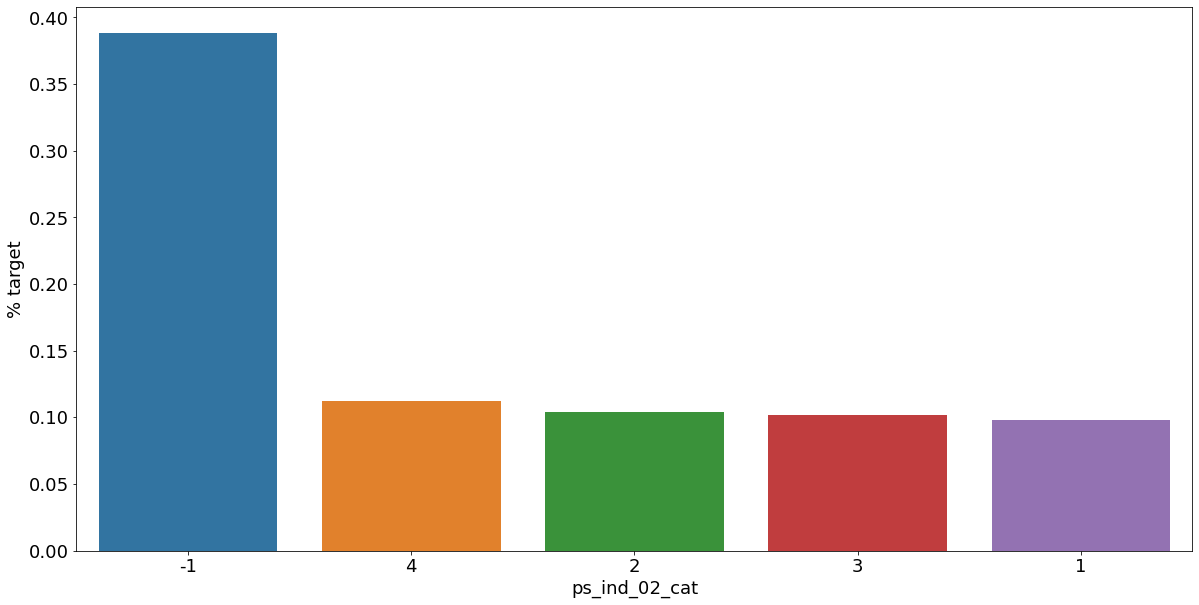

<Figure size 432x288 with 0 Axes>

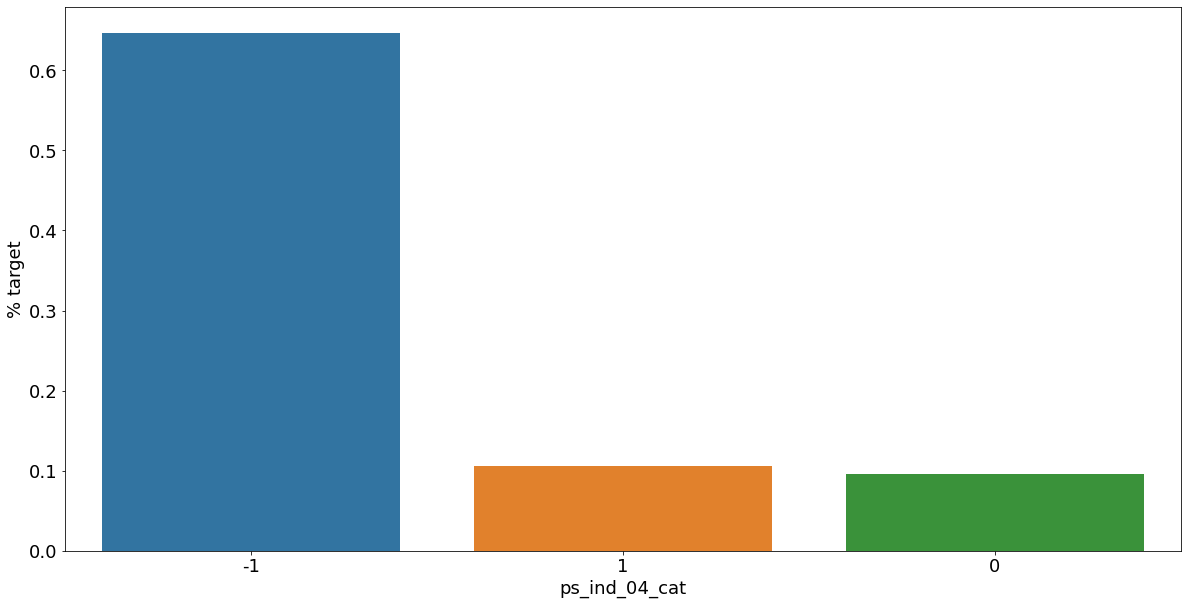

<Figure size 432x288 with 0 Axes>

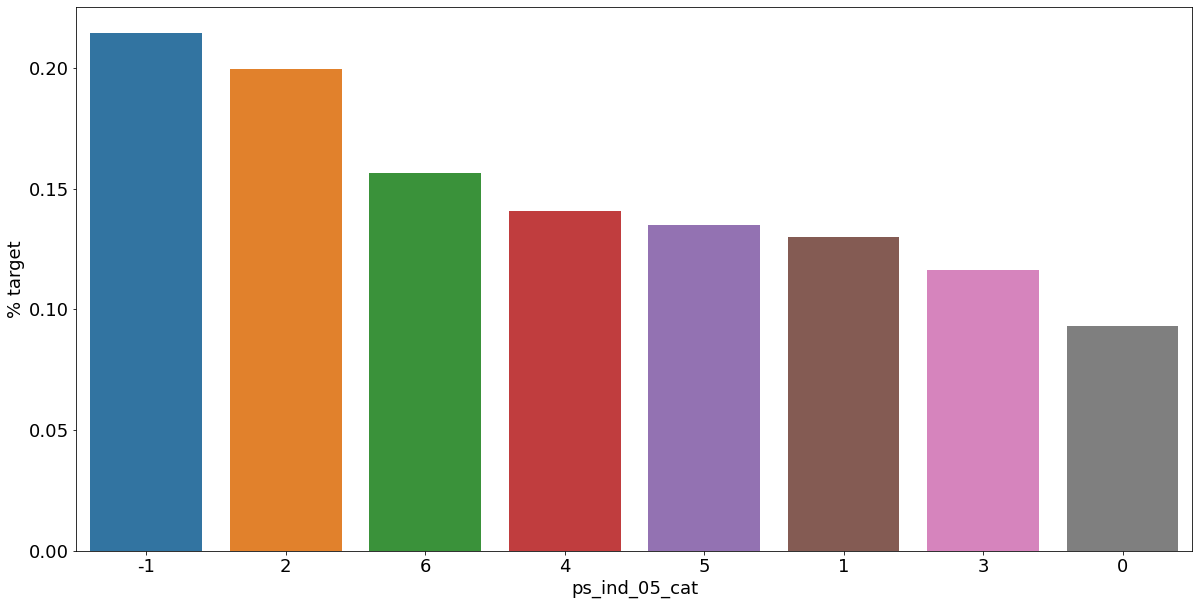

<Figure size 432x288 with 0 Axes>

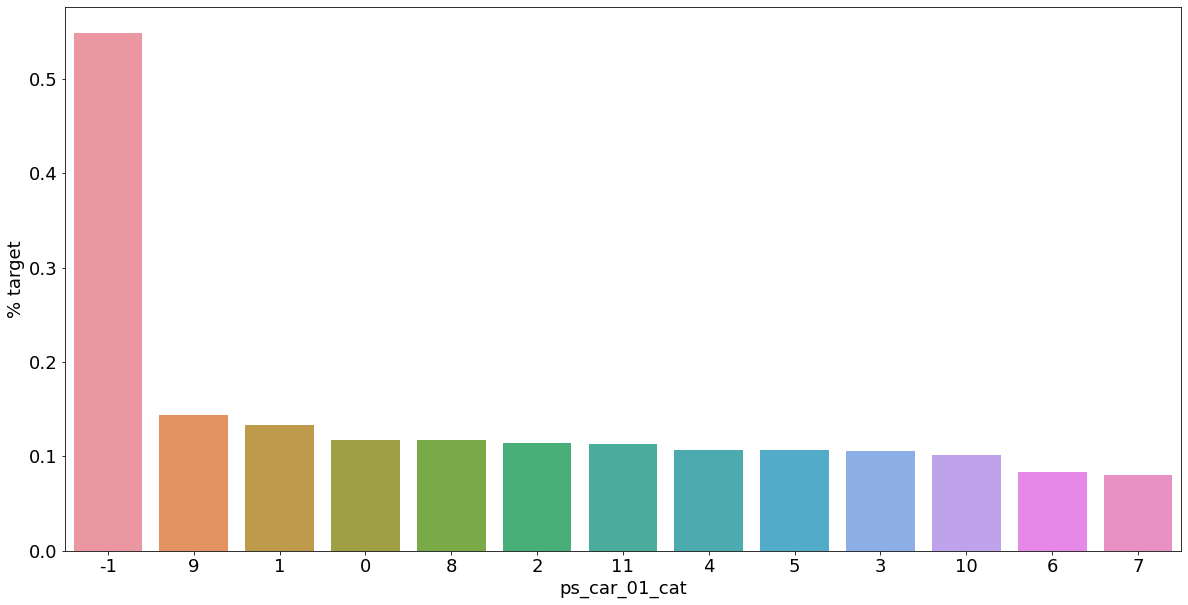

<Figure size 432x288 with 0 Axes>

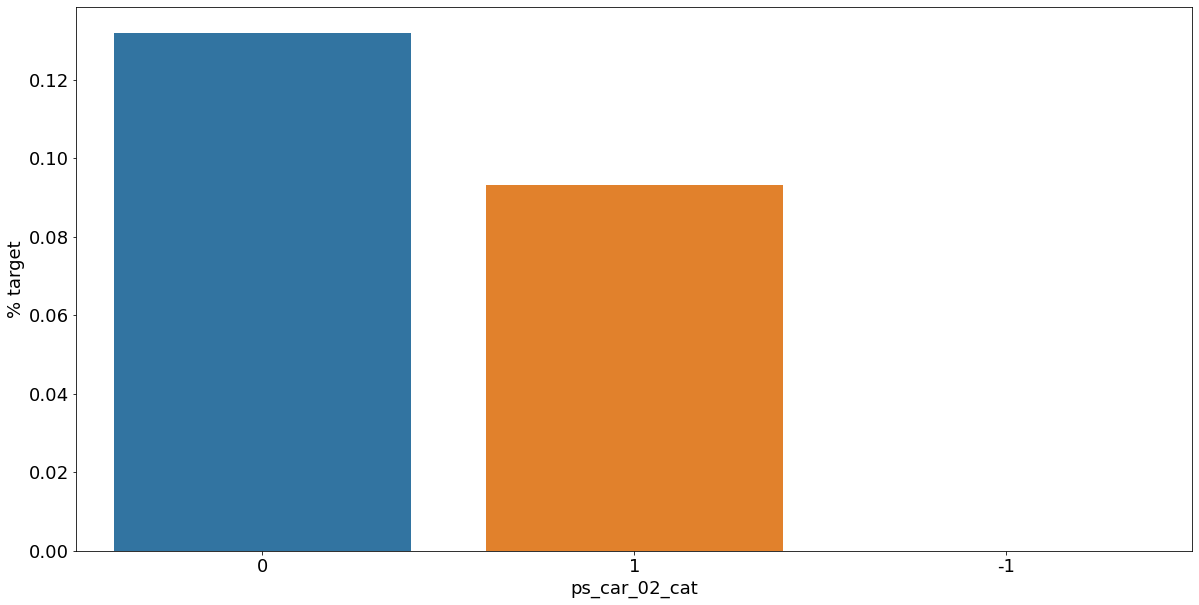

<Figure size 432x288 with 0 Axes>

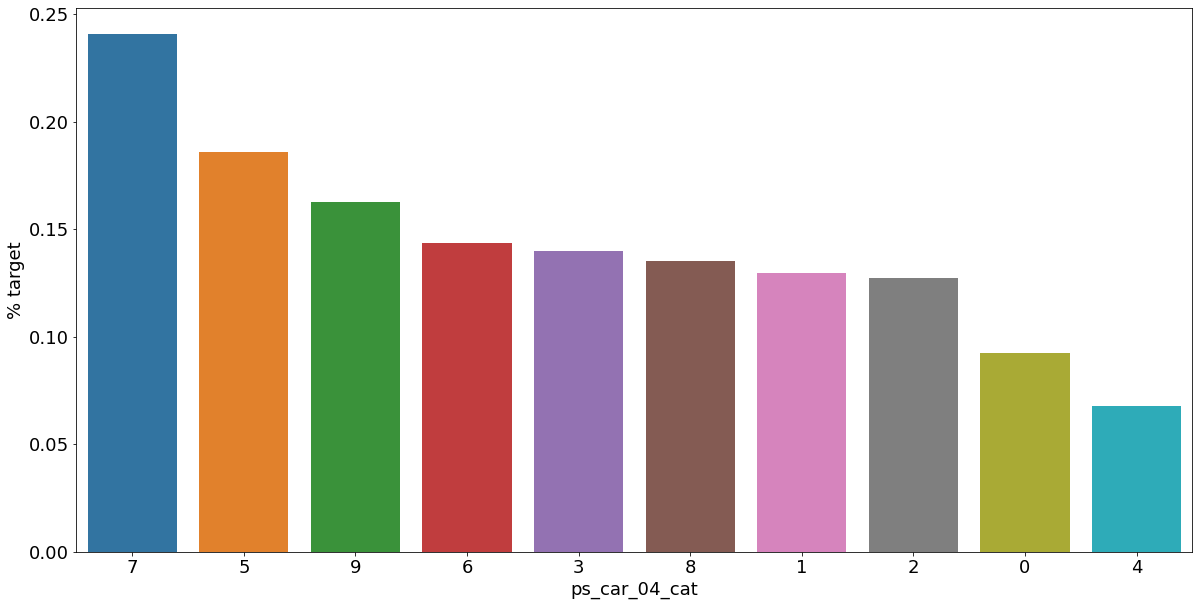

<Figure size 432x288 with 0 Axes>

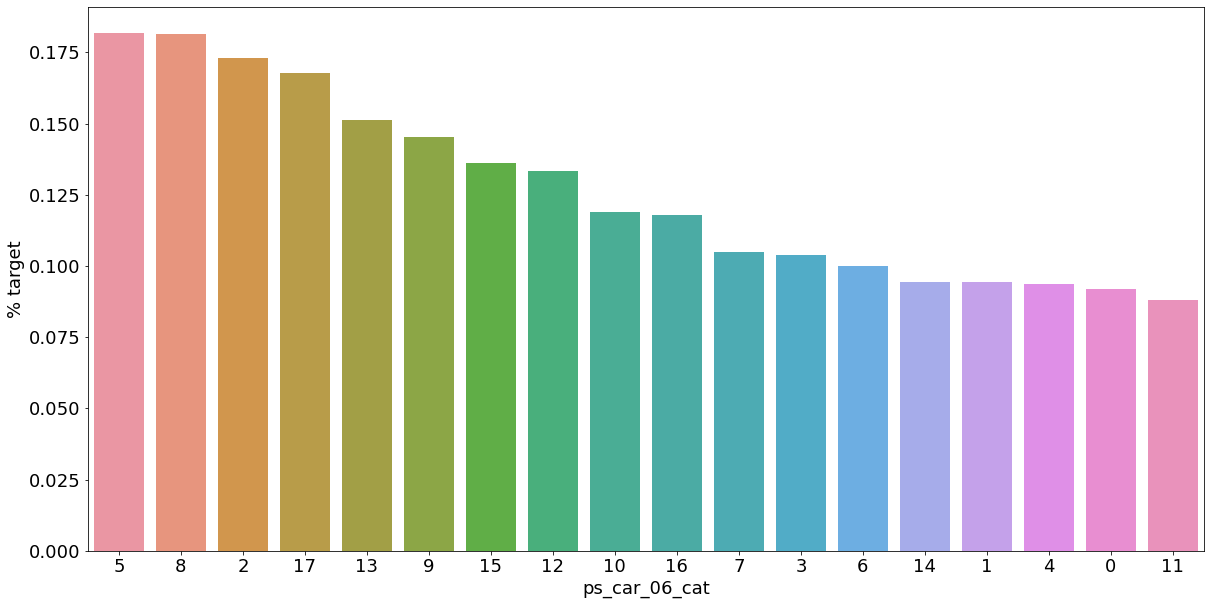

<Figure size 432x288 with 0 Axes>

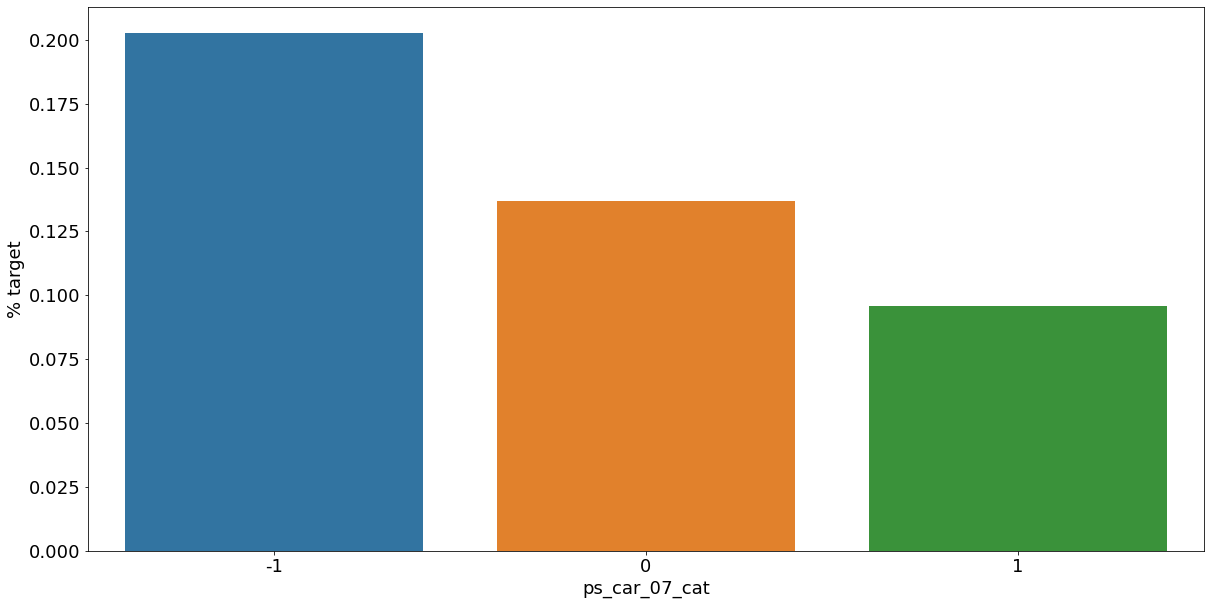

<Figure size 432x288 with 0 Axes>

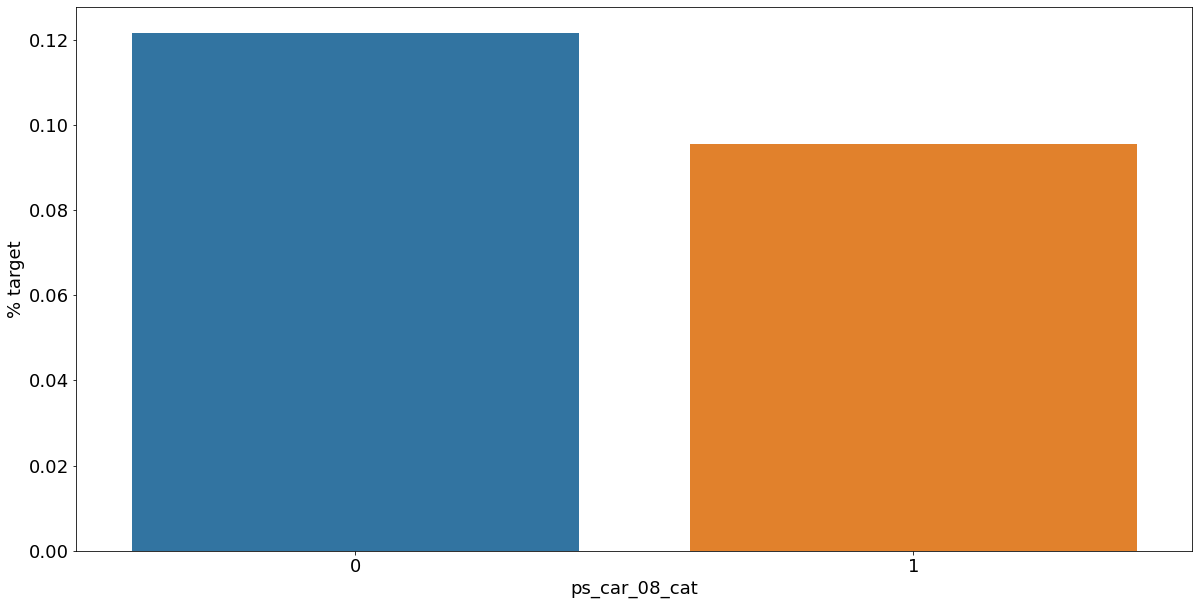

<Figure size 432x288 with 0 Axes>

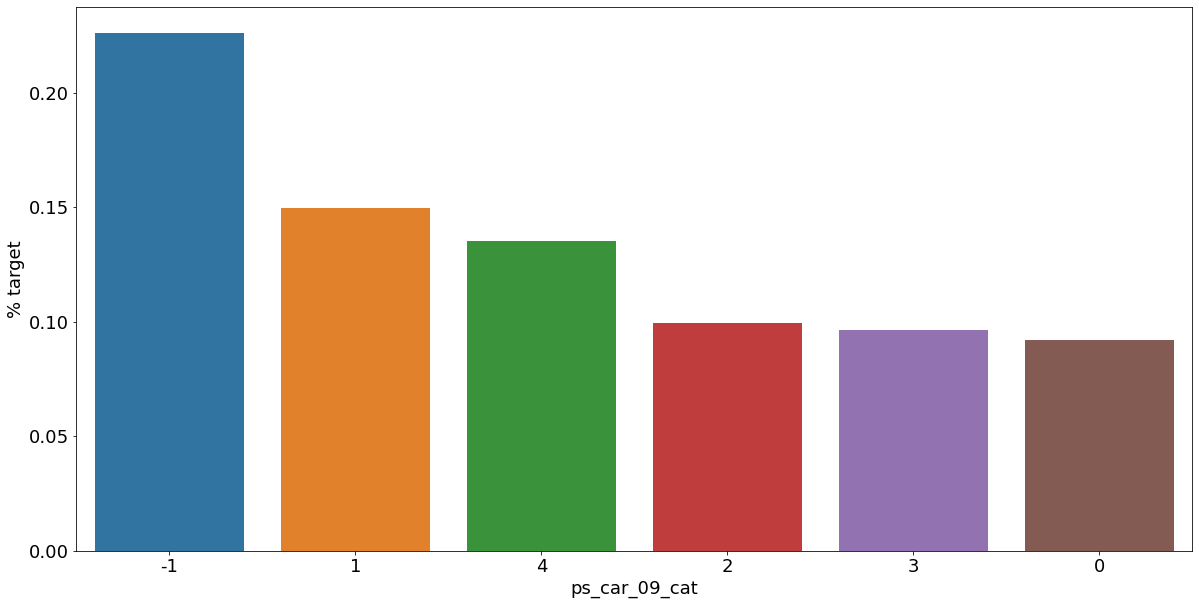

<Figure size 432x288 with 0 Axes>

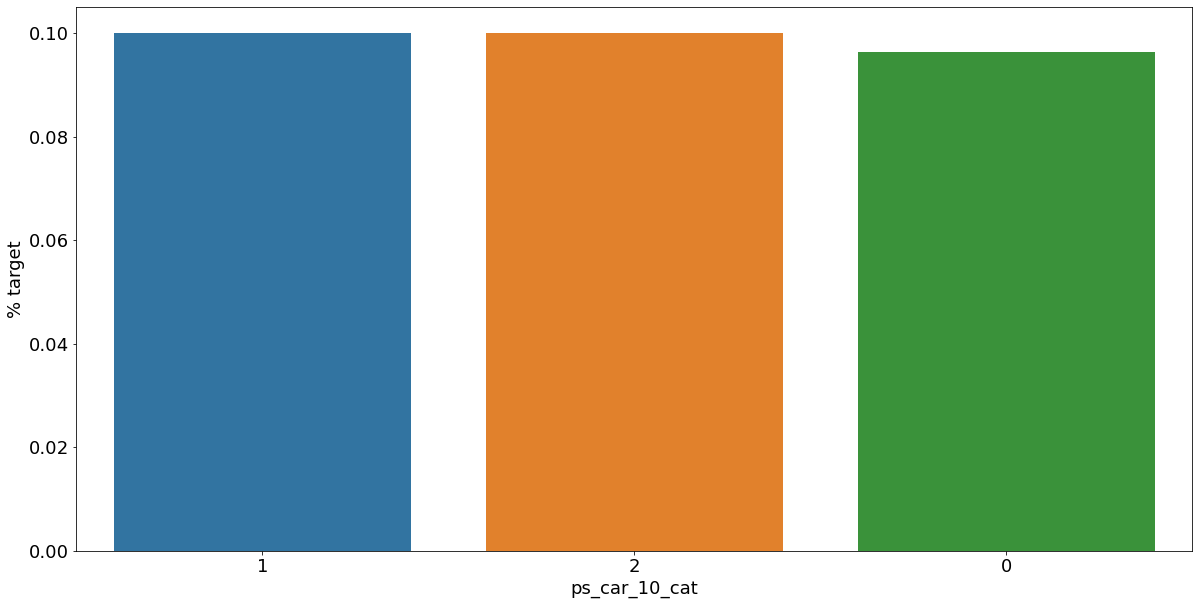

In [29]:
v=meta[(meta.level=='nominal')&(meta.keep)].index
for f in v:
    plt.figure()
    fig,ax=plt.subplots(figsize=(20,10))
    # target=1인 값의 퍼센테이지를 구해보자
    cat_perc=train[[f,'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target',ascending=False, inplace=True)
    # 막대그래프
    sns.barplot(ax=ax, x=f,y='target',data=cat_perc,order=cat_perc[f])
    plt.ylabel('% target',fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both',which='major',labelsize=18)
    plt.show();

결측치를 최빈값으로 대치하지 않고, 카테고리 값으로 분리해서 살펴본것은 바람직했던 것으로 보인다. 결측치가 있는 고객들은 보험청구를 요구했을 가능성이 더 높은것으로 나타났다. (어떤경우는 낮기도함)

#### 2) Interval variables
히트맵으로 interval 변수간의 상관관계를 살펴보자. 

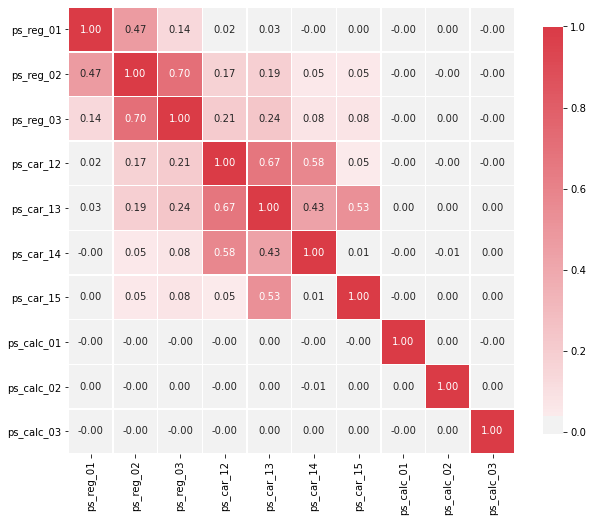

In [30]:
def corr_heatmap(v):
    correlations=train[v].corr()
    
    cmap=sns.diverging_palette(220,10,as_cmap=True)
    
    fig,ax=plt.subplots(figsize=(10,10))
    sns.heatmap(correlations,cmap=cmap,vmax=1.0, center=0, fmt='.2f',square=True, \
               linewidths=.5, annot=True, cbar_kws={'shrink':.75})
    plt.show();
    
v=meta[(meta.level=='interval')&(meta.keep)].index
corr_heatmap(v)

변수간에 상관관계가 높은 변수들이 있는것을 확인할 수 있다.
* ps_reg_02 and ps_reg_03 (0.7)
* ps_car_12 and ps_car13 (0.67)
* ps_car_12 and ps_car14 (0.58)
* ps_car_13 and ps_car15 (0.67)

In [31]:
# train데이터를 샘플링해서 시각화 살펴보기
s=train.sample(frac=0.1)

**위에서 상관관계가 높은 변수들을 lmplot으로 시각화해본다**

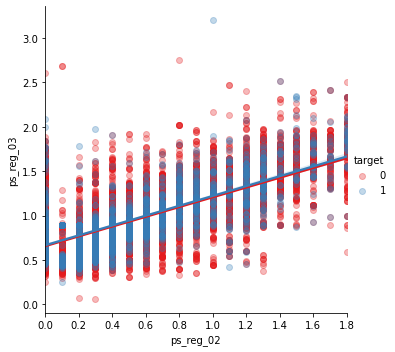

In [32]:
# 회귀모델 판단할때, 상관관계 볼때 lmplot 사용
sns.lmplot(x='ps_reg_02',y='ps_reg_03',data=s, hue='target',palette='Set1',
          scatter_kws={'alpha':0.3})
plt.show()

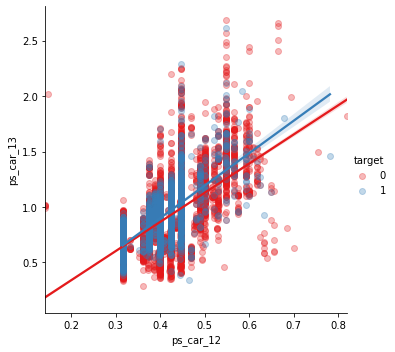

In [33]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

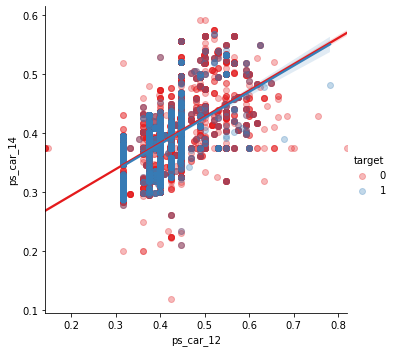

In [34]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

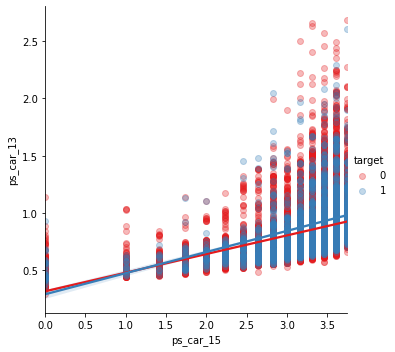

In [35]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

* 서로 상관이있는 변수를 어떻게 결정하고 남겨둘것인가? 우리는 차원을 줄이기위해 변수에 Principal Component Analysis (PCA) 를 적용해볼수있다. 그러나, 상관관계가 있는 변수들의 수가 적기때문에 모델이 알아서 하게 두기로한다.

PCA 참고 노트북 <br>
https://www.kaggle.com/bertcarremans/reducing-number-of-numerical-features-with-pca

(참고) 아래는 상관관계가 서로 낮은 변수를 lmplot으로 시각화해서 상관관계가 있는 위의 시각화 결과와 비교

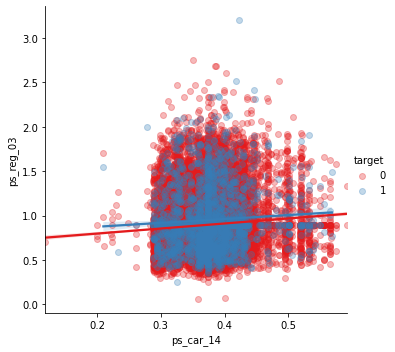

In [36]:
# ps_car_14 와 ps_reg_03 간의 상관관계는 0.08
sns.lmplot(x='ps_car_14', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

#### 3) ordinal 변수간의 상관관계 확인

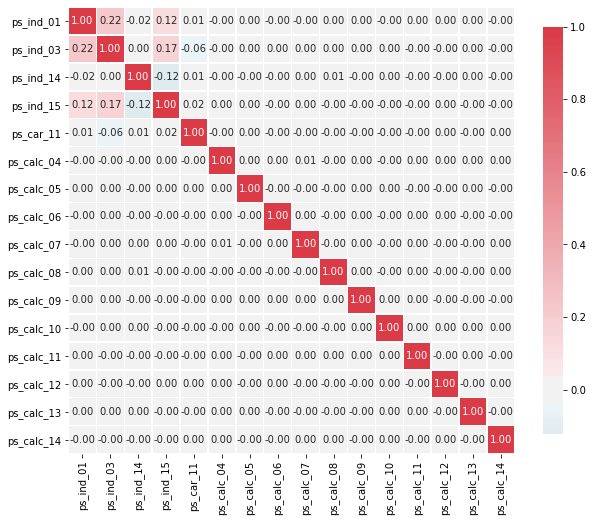

In [37]:
v=meta[(meta.level=='ordinal')&(meta.keep)].index
corr_heatmap(v)

* ordinal변수에서는 상관관계가 큰 변수들은 보이지 않는다. (target 0,1에 따라 그룹핑했을때의 분포는 확인해볼 필요 있음)

<Figure size 432x288 with 0 Axes>

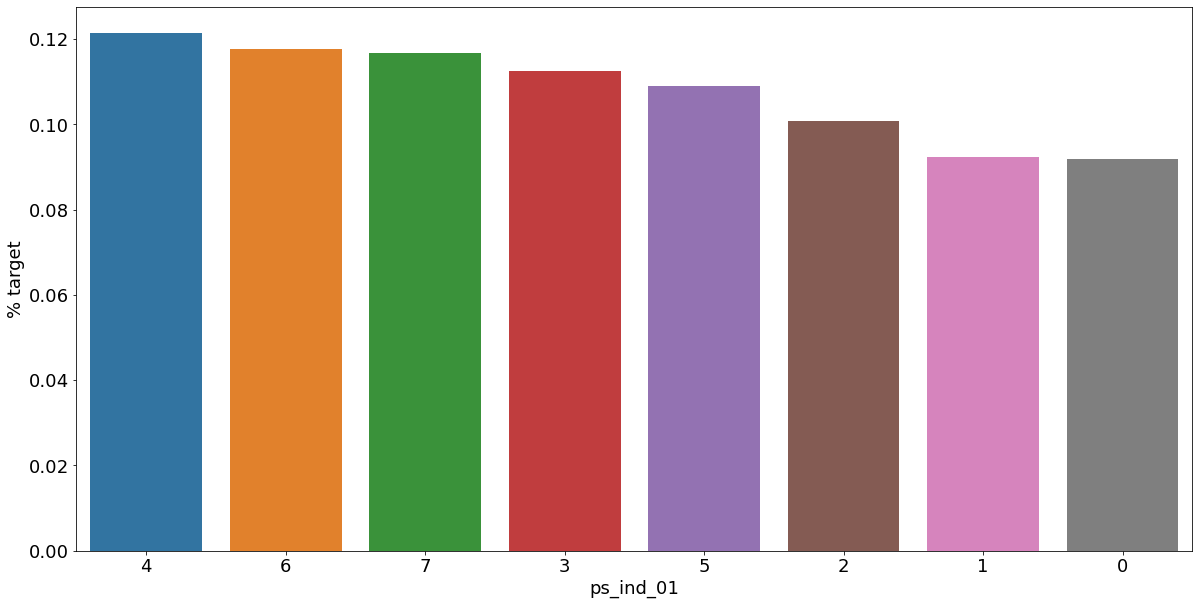

<Figure size 432x288 with 0 Axes>

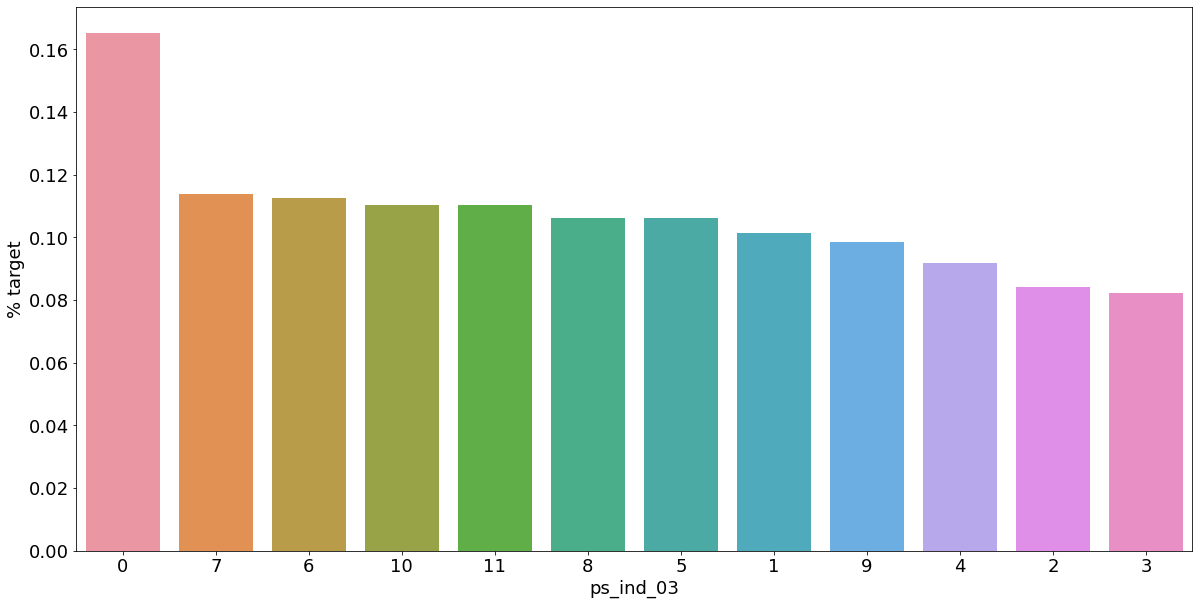

<Figure size 432x288 with 0 Axes>

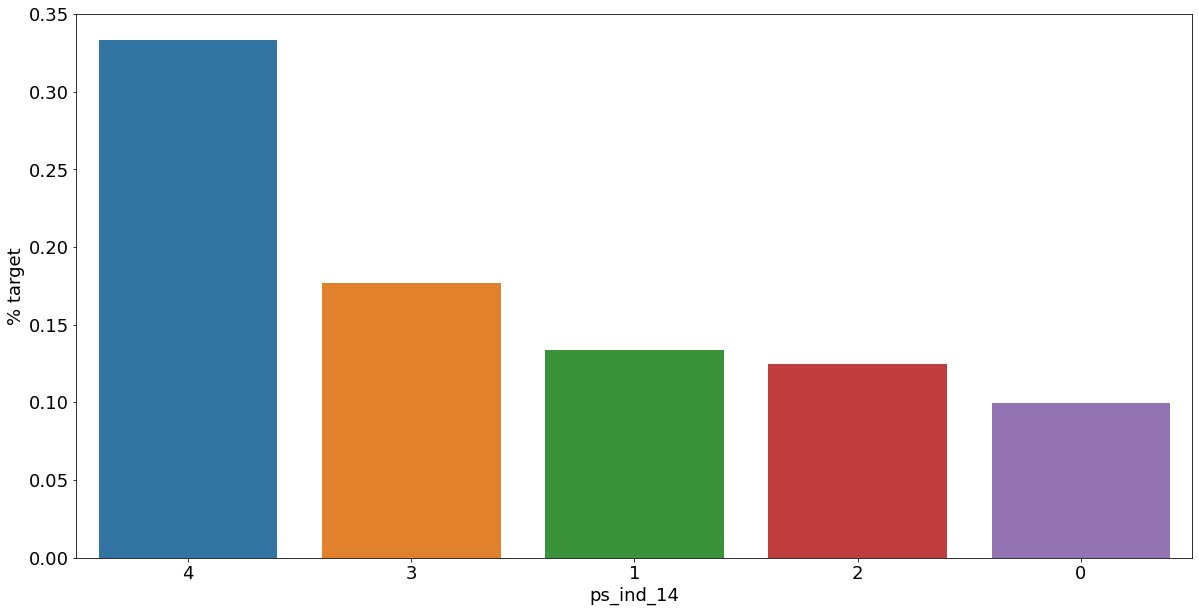

<Figure size 432x288 with 0 Axes>

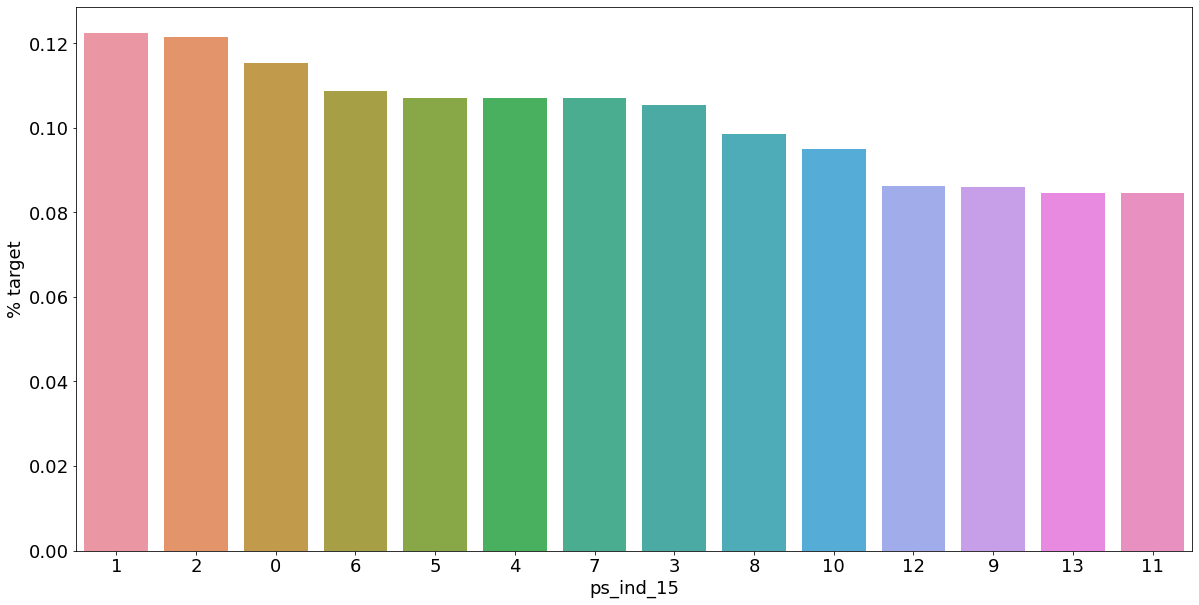

<Figure size 432x288 with 0 Axes>

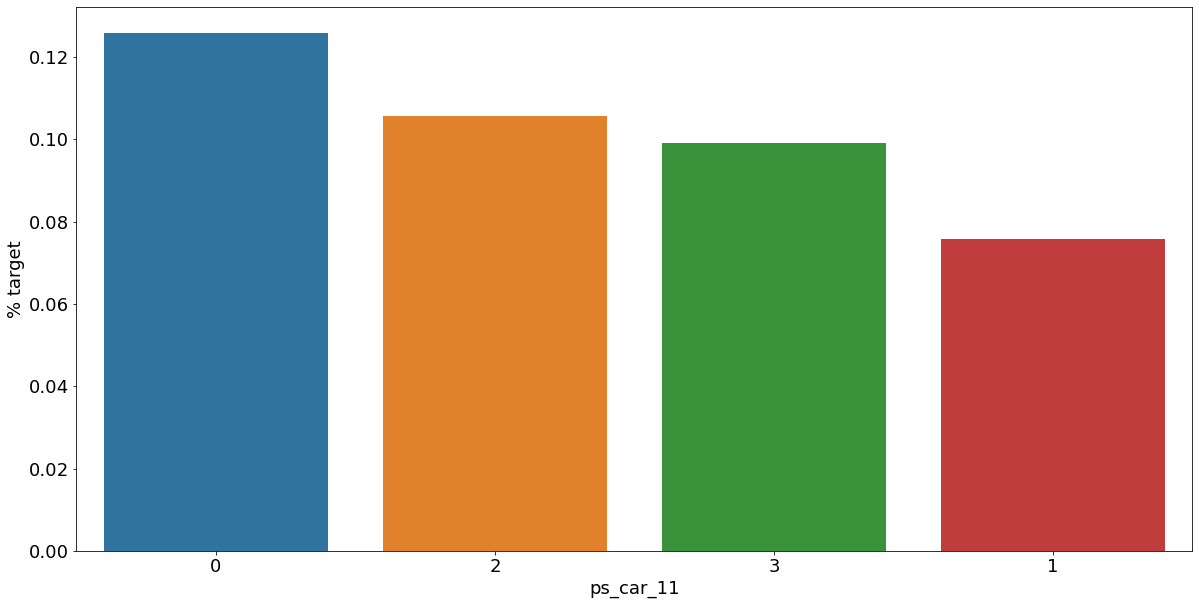

<Figure size 432x288 with 0 Axes>

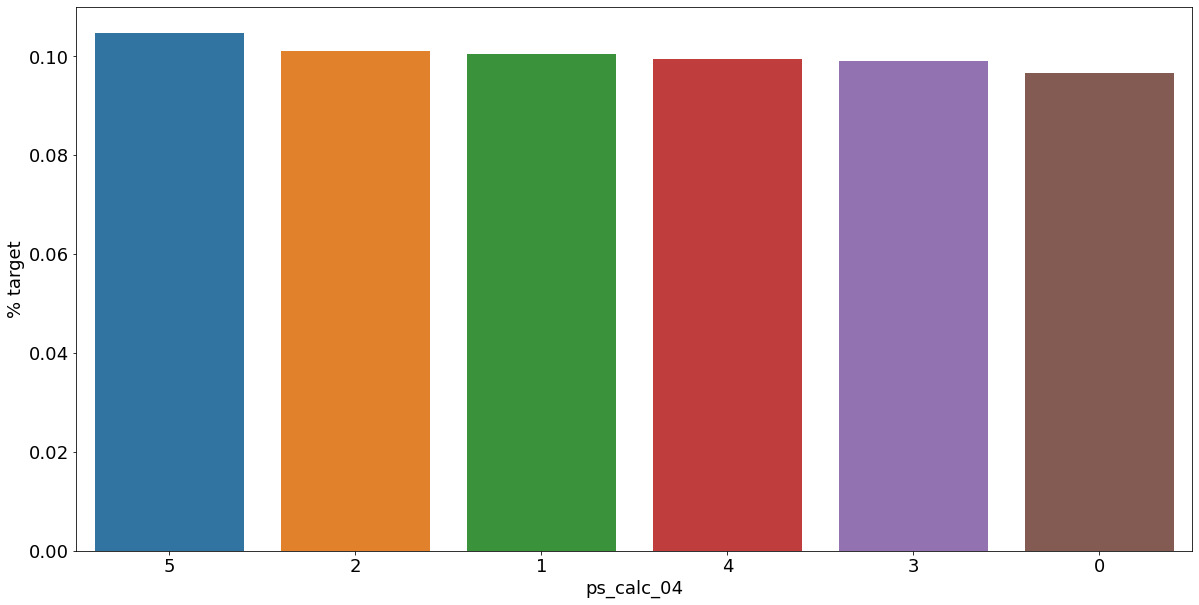

<Figure size 432x288 with 0 Axes>

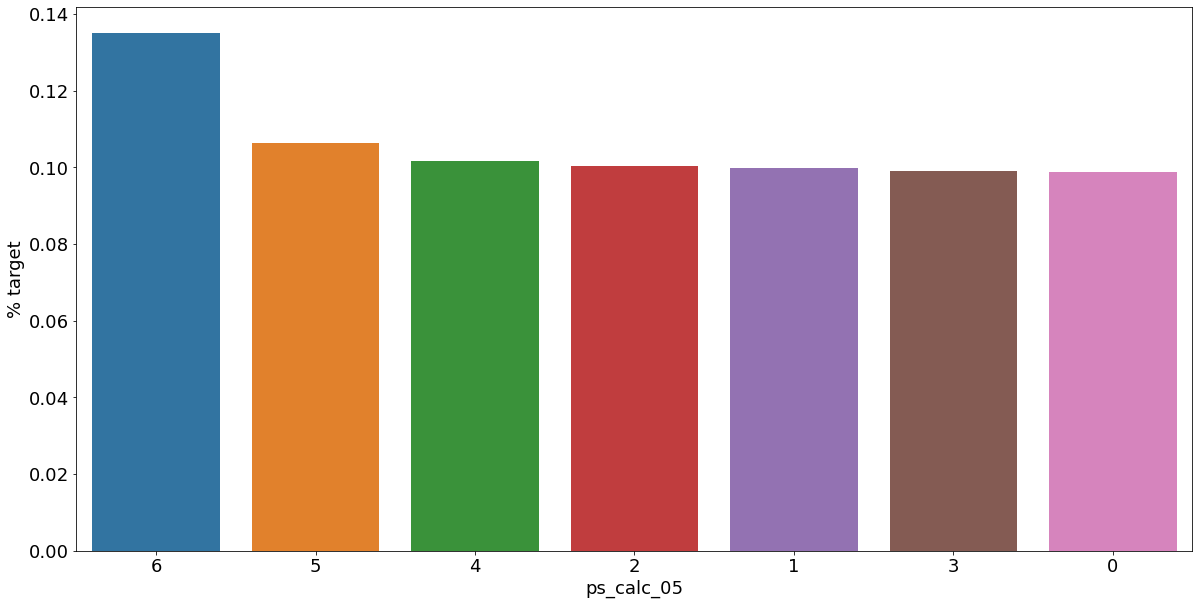

<Figure size 432x288 with 0 Axes>

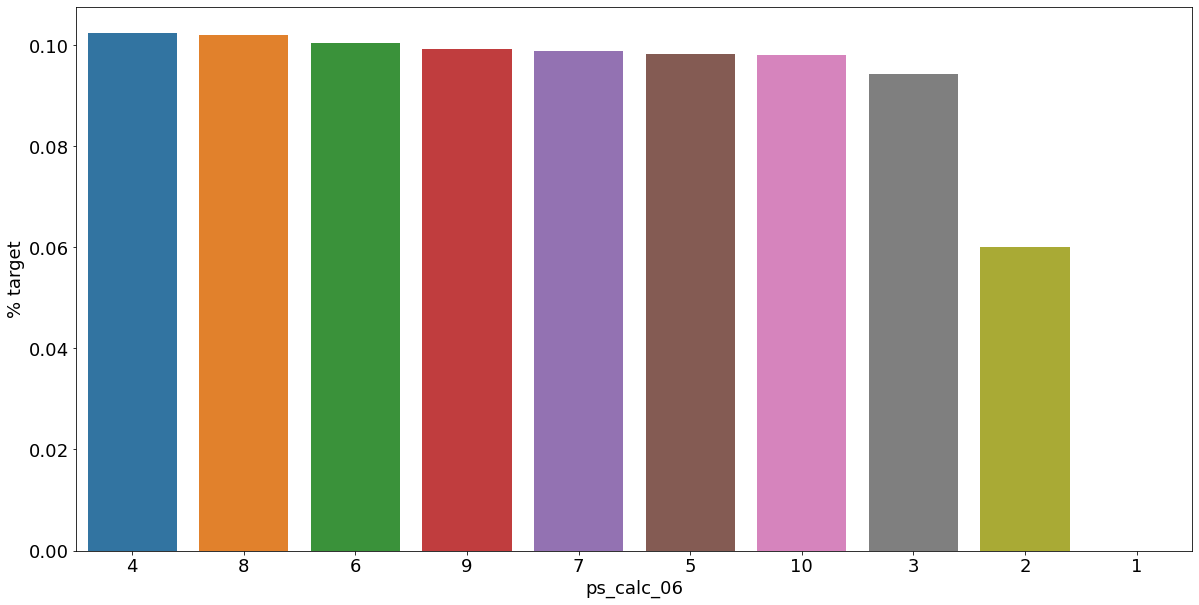

<Figure size 432x288 with 0 Axes>

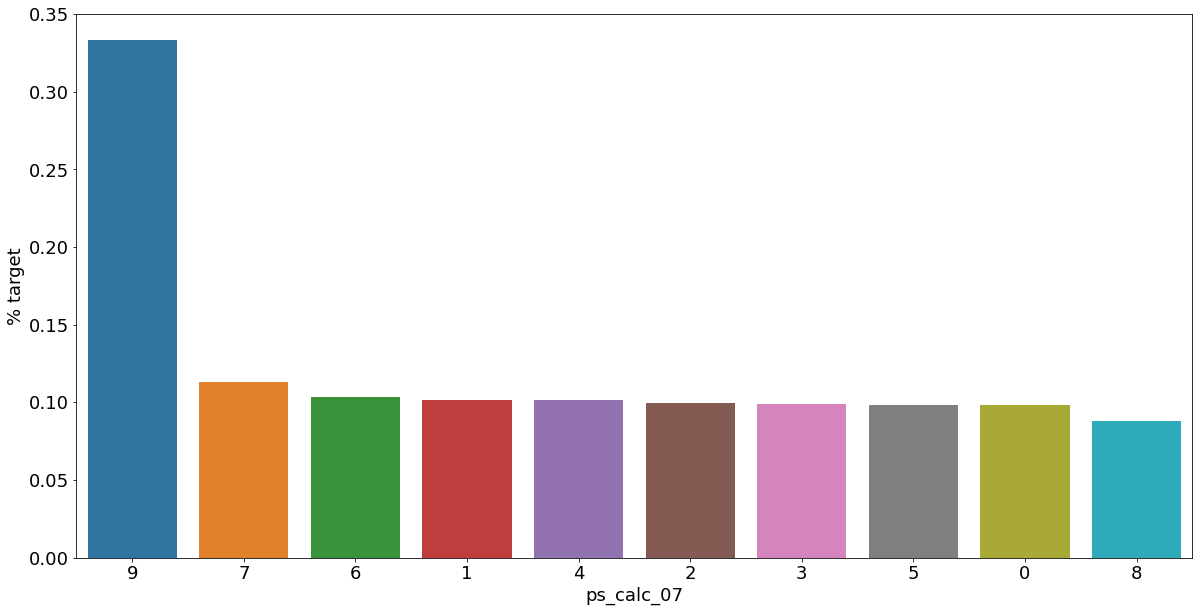

<Figure size 432x288 with 0 Axes>

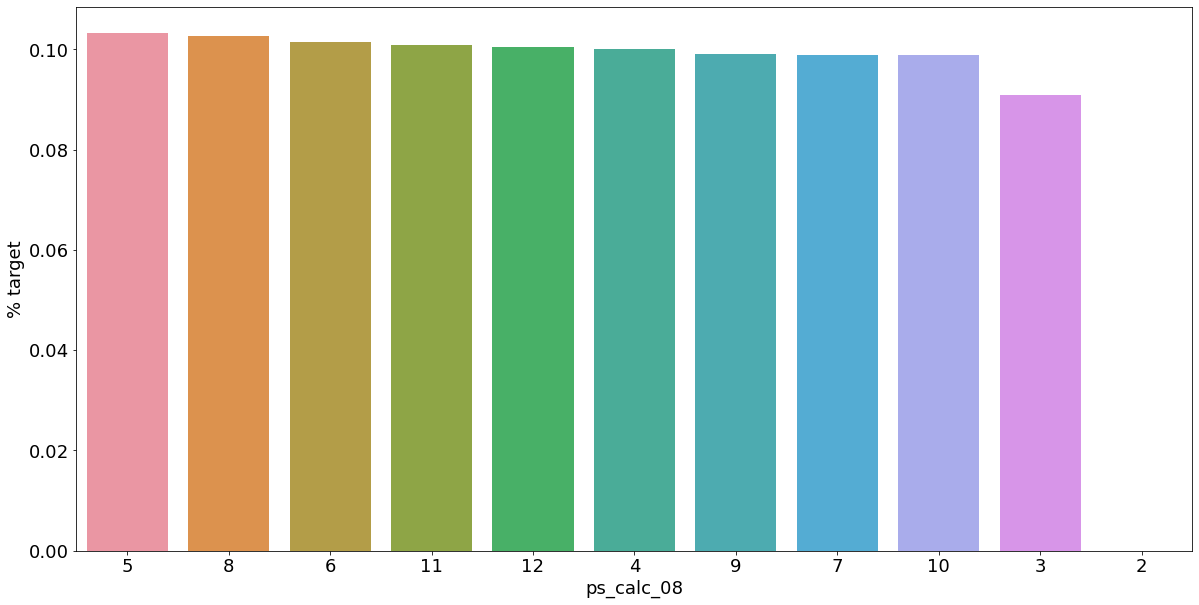

<Figure size 432x288 with 0 Axes>

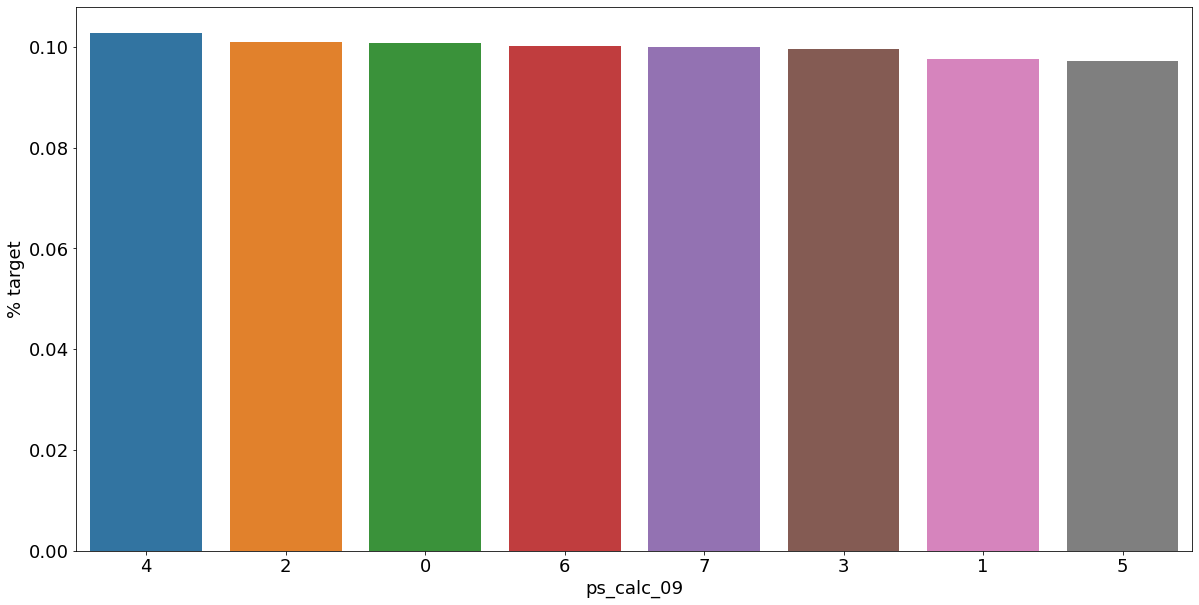

<Figure size 432x288 with 0 Axes>

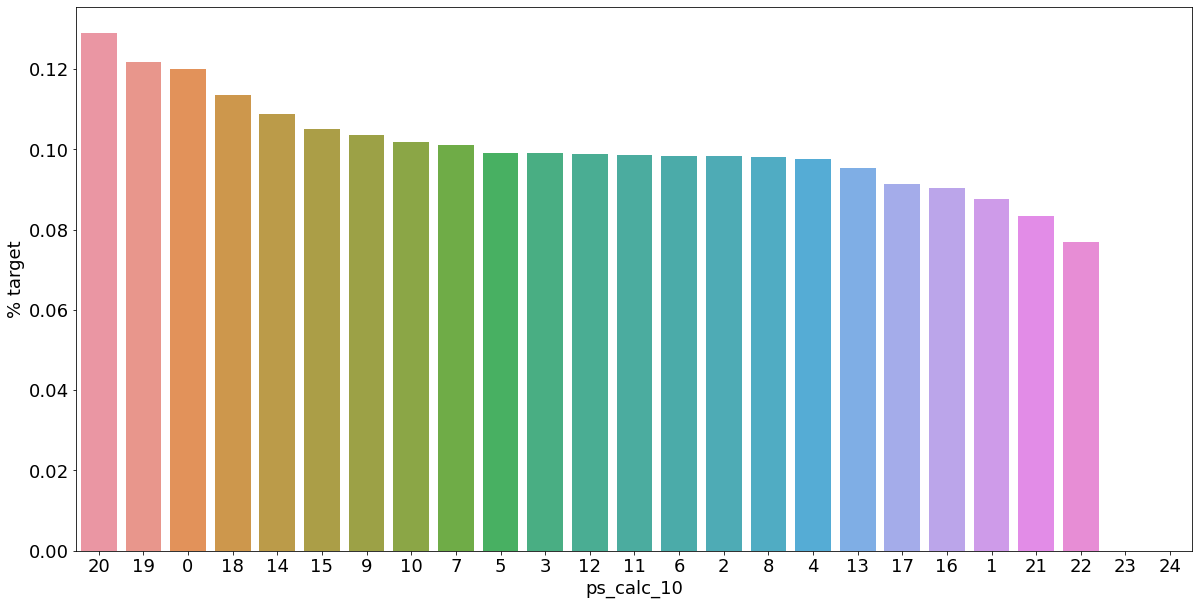

<Figure size 432x288 with 0 Axes>

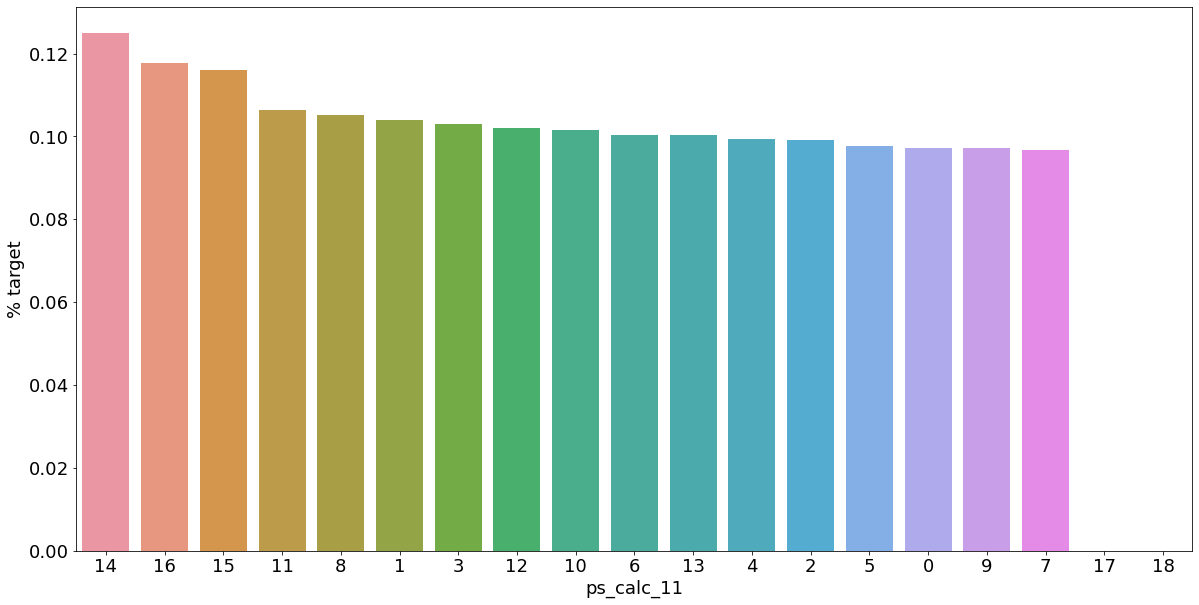

<Figure size 432x288 with 0 Axes>

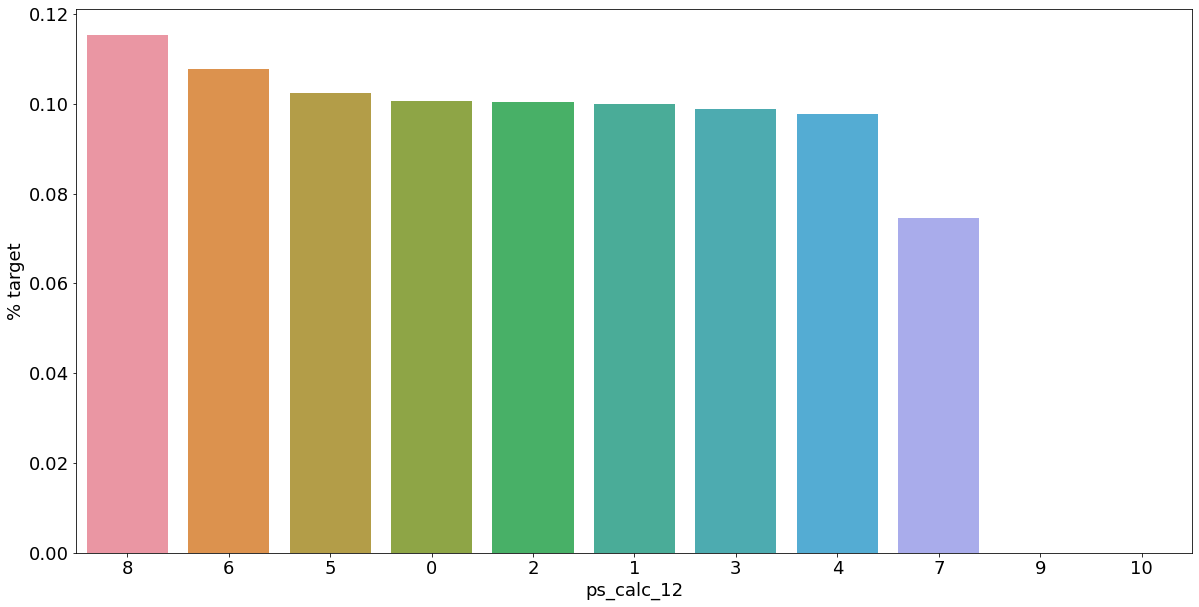

<Figure size 432x288 with 0 Axes>

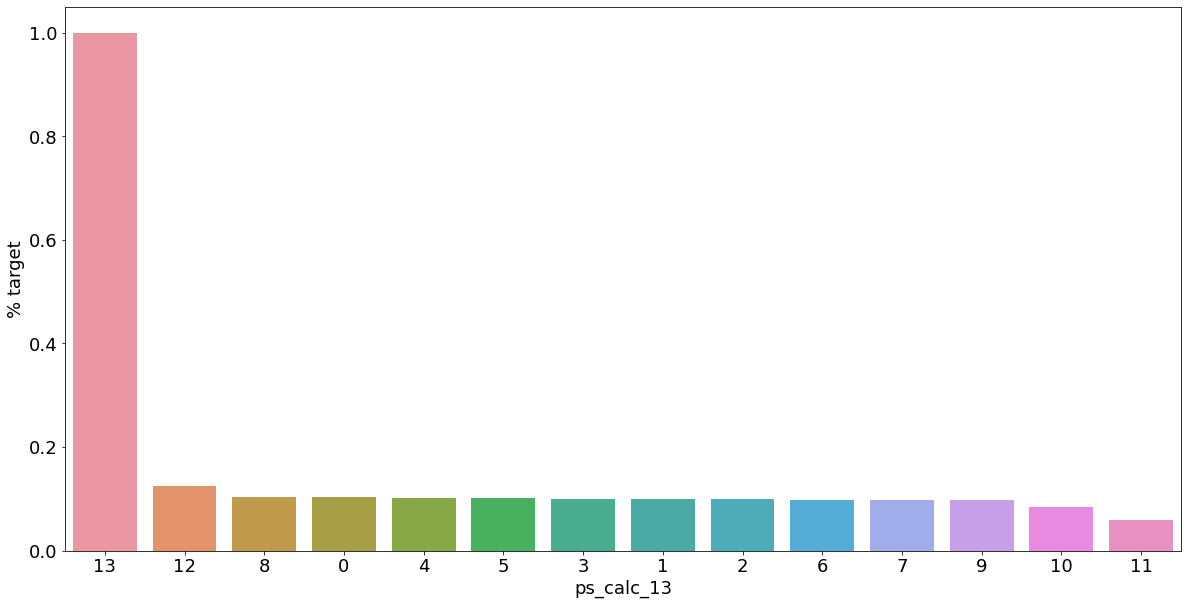

<Figure size 432x288 with 0 Axes>

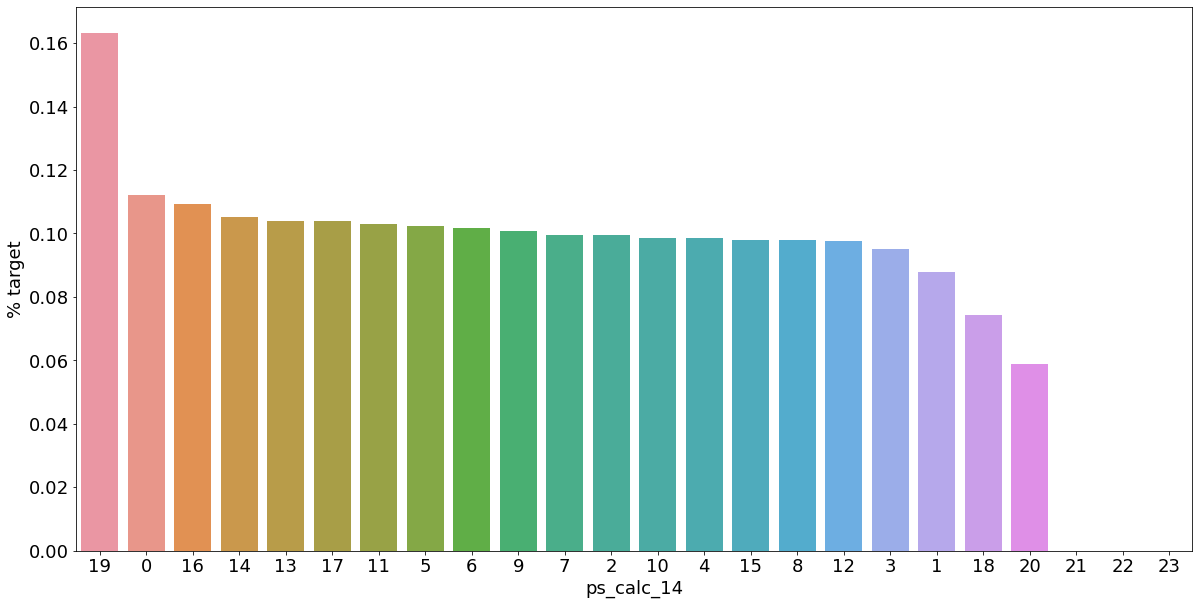

In [38]:
for f in v:
    plt.figure()
    fig,ax=plt.subplots(figsize=(20,10))
    ordinal_perc=train[[f,'target']].groupby([f],as_index=False).mean()
    ordinal_perc.sort_values(by='target',ascending=False, inplace=True)
    
    sns.barplot(ax=ax, x=f, y='target',data=ordinal_perc, order=ordinal_perc[f])
    plt.ylabel('% target',fontsize=18)
    plt.xlabel(f,fontsize=18)
    plt.tick_params(axis='both',which='major',labelsize=18)
    plt.show();

* ordinal 변수의 target별 평균을 살펴보니 ps_calc_13 변수처럼 특정 값일때 target=1 평균값이 유난히 큰 특징이 있었음

----------------------------------------
## Feature engineering

#### 1) 더미변수 만들기
카테고리변수는 어떤 순서나 단위를 나타내지 않는다. 예를들어 카테고리 2가 카테고리 1의 두배라고 할 수 없다. 

In [39]:
v=meta[(meta.level=='nominal') & (meta.keep)].index
print('더미화 하기전에 train데이터에 {}개의 변수가 있다'.format(train.shape[1]))
train=pd.get_dummies(train, columns=v, drop_first=True)
print('더미화 한 후에 train데이터에 {}개의 변수가 있다'.format(train.shape[1]))

더미화 하기전에 train데이터에 57개의 변수가 있다
더미화 한 후에 train데이터에 109개의 변수가 있다


* 따라서, 더미변수를 만듬으로써 52개의 변수가 training set에 추가되었다

#### 2) interaction 변수 만들기 (다항회귀)
https://chana.tistory.com/entry/핸즈온-머신러닝5-다항-회귀

* 사이킷런의 PolynomialFeatures를 사용하여 훈련 세트에 있는 각 특성을 제곱하여 새로운 특성으로 추가한 훈련 데이터를 만들어보자 <br>

> Q : 2차항 변수를 만드는 이유는 ? 어떤경우에 ? <br>
> A : 데이터들간의 형태가 비선형일때 데이터에 각 특성의 제곱을 추가해서 특성이 추가된 비선형 데이터를 선형회귀 모델로 훈련시키는 방법
    

In [40]:
v=meta[(meta.level=='interval')&(meta.keep)].index
# 2차항 변수 만들기
poly=PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)

# interactions변수에는 기존 데이터와 제곱한 데이터가 모두 포함된다.
interactions=pd.DataFrame(data=poly.fit_transform(train[v]),columns=poly.get_feature_names(v))
# 기존 컬럼은 제거
interactions.drop(v,axis=1,inplace=True)

# train데이터에 interaction변수를 concat한다. 즉, 기존 변수에 interval변수의 2차항 변수들을 추가
print('interaction을 추가하기 전에는 train데이터에 {} 개의 변수가 있음'.format(train.shape[1]))
train=pd.concat([train,interactions],axis=1)
print('interaction 추가한 후에 train데이터에 {}개의 변수가 있음'.format(train.shape[1]))

interaction을 추가하기 전에는 train데이터에 109 개의 변수가 있음
interaction 추가한 후에 train데이터에 164개의 변수가 있음


In [41]:
interactions.head()

,ps_reg_01^2,ps_reg_01 ps_reg_02,ps_reg_01 ps_reg_03,ps_reg_01 ps_car_12,ps_reg_01 ps_car_13,ps_reg_01 ps_car_14,ps_reg_01 ps_car_15,ps_reg_01 ps_calc_01,ps_reg_01 ps_calc_02,ps_reg_01 ps_calc_03,ps_reg_02^2,ps_reg_02 ps_reg_03,ps_reg_02 ps_car_12,ps_reg_02 ps_car_13,ps_reg_02 ps_car_14,ps_reg_02 ps_car_15,ps_reg_02 ps_calc_01,ps_reg_02 ps_calc_02,ps_reg_02 ps_calc_03,ps_reg_03^2,ps_reg_03 ps_car_12,ps_reg_03 ps_car_13,ps_reg_03 ps_car_14,ps_reg_03 ps_car_15,ps_reg_03 ps_calc_01,ps_reg_03 ps_calc_02,ps_reg_03 ps_calc_03,ps_car_12^2,ps_car_12 ps_car_13,ps_car_12 ps_car_14,ps_car_12 ps_car_15,ps_car_12 ps_calc_01,ps_car_12 ps_calc_02,ps_car_12 ps_calc_03,ps_car_13^2,ps_car_13 ps_car_14,ps_car_13 ps_car_15,ps_car_13 ps_calc_01,ps_car_13 ps_calc_02,ps_car_13 ps_calc_03,ps_car_14^2,ps_car_14 ps_car_15,ps_car_14 ps_calc_01,ps_car_14 ps_calc_02,ps_car_14 ps_calc_03,ps_car_15^2,ps_car_15 ps_calc_01,ps_car_15 ps_calc_02,ps_car_15 ps_calc_03,ps_calc_01^2,ps_calc_01 ps_calc_02,ps_calc_01 ps_calc_03,ps_calc_02^2,ps_calc_02 ps_calc_03,ps_calc_03^2
0,0.36,0.36,0.502892,0.221269,0.324362,0.207413,1.200000,0.54,0.18,0.00,0.36,0.502892,0.221269,0.324362,0.207413,1.200000,0.54,0.18,0.00,0.702500,0.309095,0.453108,0.289739,1.676305,0.754337,0.251446,0.000000,0.136,0.199365,0.127483,0.737564,0.331904,0.110635,0.000000,0.292252,0.186880,1.081207,0.486543,0.162181,0.000000,0.1195,0.691375,0.311119,0.103706,0.000000,4.0,1.800000,0.600000,0.000000,0.81,0.27,0.00,0.09,0.00,0.00
1,0.81,0.54,0.655596,0.381838,0.344658,0.340933,0.000000,0.18,0.00,0.54,0.36,0.437064,0.254558,0.229772,0.227288,0.000000,0.12,0.00,0.36,0.530625,0.309051,0.278958,0.275943,0.000000,0.145688,0.000000,0.437064,0.180,0.162473,0.160717,0.000000,0.084853,0.000000,0.254558,0.146653,0.145068,0.000000,0.076591,0.000000,0.229772,0.1435,0.000000,0.075763,0.000000,0.227288,0.0,0.000000,0.000000,0.000000,0.04,0.00,0.12,0.00,0.00,0.36
2,0.81,0.54,0.782340,0.360000,0.732844,0.362131,2.984962,0.27,0.81,0.09,0.36,0.521560,0.240000,0.488563,0.241421,1.989975,0.18,0.54,0.06,0.755625,0.347707,0.707819,0.349765,2.883032,0.260780,0.782340,0.086927,0.160,0.325708,0.160947,1.326650,0.120000,0.360000,0.040000,0.663037,0.327637,2.700631,0.244281,0.732844,0.081427,0.1619,1.334504,0.120710,0.362131,0.040237,11.0,0.994987,2.984962,0.331662,0.09,0.27,0.03,0.81,0.09,0.01
3,0.36,0.90,1.023523,0.240000,0.503032,0.227051,2.163331,0.48,0.24,0.06,2.25,2.558808,0.600000,1.257580,0.567627,5.408327,1.20,0.60,0.15,2.910000,0.682349,1.430181,0.645532,6.150610,1.364698,0.682349,0.170587,0.160,0.335355,0.151367,1.442221,0.320000,0.160000,0.040000,0.702893,0.317260,3.022847,0.670710,0.335355,0.083839,0.1432,1.364405,0.302734,0.151367,0.037842,13.0,2.884441,1.442221,0.360555,0.64,0.32,0.08,0.16,0.04,0.01
4,0.64,0.64,0.869253,0.320000,0.724622,0.307870,2.884441,0.48,0.40,0.72,0.64,0.869253,0.320000,0.724622,0.307870,2.884441,0.48,0.40,0.72,1.180625,0.434626,0.984186,0.418151,3.917668,0.651939,0.543283,0.977909,0.160,0.362311,0.153935,1.442221,0.240000,0.200000,0.360000,0.820432,0.348577,3.265825,0.543466,0.452888,0.815199,0.1481,1.387552,0.230903,0.192419,0.346354,13.0,2.163331,1.802776,3.244996,0.36,0.30,0.54,0.25,0.45,0.81


-----------------
## Feature Selection
* 분산이 0이거나 작은 feature제거
* 사이킷런의 VarianceThreshold를 이용하면 간편하게 분산이 0인 feature를 제거할 수 있다. 하지만, 이 경우에는 분산이 0인 변수가 없음. 따라서 분산이 1% 미만인 변수를 제거한다고하면 31개의 변수를 제거할 수 있음.

> Q : 분산이 작은 변수를 제거해야하는 이유 ? <br>

> A : 예측모델에서 중요한 특성이란, 타겟과의 상관관계가 큰 특성을 의미한다. 그런데 상관관계에 앞서 어떤 특성의 값 자체가 표본에 따라 그다지 변하지 않는다면, 예측에 별 도움이 되지 않을 가능성이 높다.  <br>
(ex. 남자를 상대로한 설문조사 데이터에서 남자 라는 성별특성은 무의미함.)<br>
따라서, 표본 변화에 따른 데이터 값의 변화량 즉, 분산이 기준치보다낮은 특성은 제거하는것

In [42]:
selector=VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id','target'],axis=1))

# np.vectorize(사용자 정의 함수명, otypes = ...)
## Function to toggle boolean array elements
## get_support() 하면 True,False값이 나오는데 이중에서 False값만 반환하기위해 f함수지정
f=np.vectorize(lambda x: not x)

v=train.drop(['id','target'],axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


### Selecting features with a Random Forest and SelectFromModel

https://blog.naver.com/PostView.nhn?blogId=bosongmoon&logNo=221807565642

In [43]:
X_train=train.drop(['id','target'],axis=1)
y_train=train['target']

feat_labels=X_train.columns

rf=RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train,y_train)
importances=rf.feature_importances_

# np.argsort() : 작은 것 부터 순서대로 뽑아내는 index
# [::-1] 다시 역순으로
indices=np.argsort(rf.feature_importances_)[::-1]   # 중요도 큰순으로 나열

# 순서, 30으로 나누기, 인덱스와 중요도 출력
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f+1,30,feat_labels[indices[f]], importances[indices[f]]))


 1) ps_car_11_cat_te               0.021159
 2) ps_car_13^2                    0.017303
 3) ps_car_13                      0.017301
 4) ps_car_12 ps_car_13            0.017235
 5) ps_car_13 ps_car_14            0.017129
 6) ps_reg_03 ps_car_13            0.017123
 7) ps_car_13 ps_car_15            0.016827
 8) ps_reg_01 ps_car_13            0.016823
 9) ps_reg_03 ps_car_14            0.016259
10) ps_reg_03 ps_car_12            0.015592
11) ps_reg_03 ps_car_15            0.015163
12) ps_car_14 ps_car_15            0.015020
13) ps_car_13 ps_calc_01           0.014759
14) ps_car_13 ps_calc_03           0.014683
15) ps_car_13 ps_calc_02           0.014658
16) ps_reg_01 ps_reg_03            0.014643
17) ps_reg_02 ps_car_13            0.014634
18) ps_reg_01 ps_car_14            0.014362
19) ps_reg_03^2                    0.014268
20) ps_reg_03                      0.014229
21) ps_reg_03 ps_calc_02           0.013812
22) ps_reg_03 ps_calc_03           0.013765
23) ps_reg_03 ps_calc_01        

#### SelectFromModel 
* 모델 훈련이 끝난 후 사용자가 지정한 임계값을 기반으로 특성 선택


In [44]:
# rf모델 내 특성 중 지니계수 값이 mediand이상일 경우의 특징 선택
sfm=SelectFromModel(rf, threshold='median',prefit=True)
print('Number of features before selection: {}'.format(X_train.shape[1]))

# 학습시킨 sfm을 x_train에 적용
n_features=sfm.transform(X_train).shape[1]
print('Number of features after selection: {}'.format(n_features))

# sfm.get_support() 하면 선택된 변수일경우 True, 아니면 False
## 최종 선택 변수
selected_vars=list(feat_labels[sfm.get_support()])

Number of features before selection: 162
Number of features after selection: 81


In [45]:
selected_vars

['ps_ind_01',
 'ps_ind_03',
 'ps_ind_15',
 'ps_reg_01',
 'ps_reg_02',
 'ps_reg_03',
 'ps_car_11',
 'ps_car_12',
 'ps_car_13',
 'ps_car_14',
 'ps_car_15',
 'ps_calc_01',
 'ps_calc_02',
 'ps_calc_03',
 'ps_calc_04',
 'ps_calc_05',
 'ps_calc_06',
 'ps_calc_07',
 'ps_calc_08',
 'ps_calc_09',
 'ps_calc_10',
 'ps_calc_11',
 'ps_calc_12',
 'ps_calc_13',
 'ps_calc_14',
 'ps_car_11_cat_te',
 'ps_reg_01^2',
 'ps_reg_01 ps_reg_02',
 'ps_reg_01 ps_reg_03',
 'ps_reg_01 ps_car_12',
 'ps_reg_01 ps_car_13',
 'ps_reg_01 ps_car_14',
 'ps_reg_01 ps_car_15',
 'ps_reg_01 ps_calc_01',
 'ps_reg_01 ps_calc_02',
 'ps_reg_01 ps_calc_03',
 'ps_reg_02^2',
 'ps_reg_02 ps_reg_03',
 'ps_reg_02 ps_car_12',
 'ps_reg_02 ps_car_13',
 'ps_reg_02 ps_car_14',
 'ps_reg_02 ps_car_15',
 'ps_reg_02 ps_calc_01',
 'ps_reg_02 ps_calc_02',
 'ps_reg_02 ps_calc_03',
 'ps_reg_03^2',
 'ps_reg_03 ps_car_12',
 'ps_reg_03 ps_car_13',
 'ps_reg_03 ps_car_14',
 'ps_reg_03 ps_car_15',
 'ps_reg_03 ps_calc_01',
 'ps_reg_03 ps_calc_02',
 'ps_re

In [46]:
train = train[selected_vars + ['target']]

----------
## Feature scaling

In [47]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[-0.45941104, -1.26665356,  1.05087653, ..., -0.72553616,
        -1.01071913, -1.06173767],
       [ 1.55538958,  0.95034274, -0.63847299, ..., -1.06120876,
        -1.01071913,  0.27907892],
       [ 1.05168943, -0.52765479, -0.92003125, ...,  1.95984463,
        -0.56215309, -1.02449277],
       ...,
       [-0.9631112 ,  0.58084336,  0.48776003, ..., -0.46445747,
         0.18545696,  0.27907892],
       [-0.9631112 , -0.89715418, -1.48314775, ..., -0.91202093,
        -0.41263108,  0.27907892],
       [-0.45941104, -1.26665356,  1.61399304, ...,  0.28148164,
        -0.11358706, -0.72653353]])

------------------------------------------------
# test-set 동일하게 전처리 후 submission파일 생성

### Data Preprocessing
* 결측치 처리 (평균, 최빈값 대치)
* distinct value가 너무 많은 변수 drop
* 더미변수 추가
* 2차항변수 추가
* train 데이터에서 다른 사람 코드로 encoded한 컬럼 ps_car_11_cat_te 은 우선 제거
* train-set의 rf, SelectFromModel 과정을 통해 주요변수 (selected_vars) 도출했고 test-set도 이 변수만 추출
* 데이터 스케일링 (StandardScaler)
    * train-set에는 fit_transform, test-set에는 transform만 적용
